# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "/home/carnd/code/traffic-signs/data/train.p"
testing_file = "/home/carnd/code/traffic-signs/data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.
import numpy as np

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


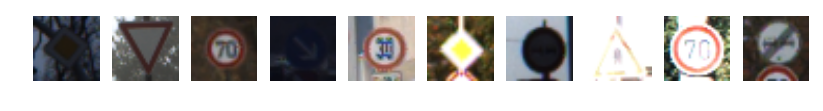

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Number of random images to get
n_images = 10

# Generate a list of 10 random indices within X_train range
indices = np.random.randint(0, n_train - 1, size=n_images)

f = plt.figure(figsize=(n_images, 1))

# Display 10 random images from the training set
for i, idx in enumerate(indices):
    ax = f.add_subplot(1, n_images, (i + 1))
    ax.axis('off')
    ax.imshow(X_train[idx])

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

def grayscale(images):
    """Convert to from RGB to Grayscale"""
    gray_images = []

    for image in images:
        gray_image = np.dot(image, [0.299, 0.587, 0.114])
        gray_images.append(gray_image)
        
    return np.array(gray_images)

def normalize(images):
    """Divide image date by 255 so range is between 0 and 1"""
    return images / 255.

def flatten(images):
    """Flatten the image data"""
    return images.reshape(-1, np.prod(images[0].shape))

def prepare_images(images):
    """Run images through preprocessing steps"""
    images = images.astype(np.float32)
    images = grayscale(images)
    images = normalize(images)
    images = flatten(images)
    return images

def prepare_labels(labels, encoder):
    labels = encoder.transform(labels)
    labels = labels.astype(np.float32)
    return labels

# Save the original shape of the images
image_shape = X_train[0].shape

# Preprocess training and test data
print("Preparing training images")
images_train = prepare_images(X_train)

print("Preparing test images")
images_test = prepare_images(X_test)

# Preprocess training and test labels
encoder = LabelBinarizer()
encoder.fit(y_train)

print("Preparing training labels")
labels_train = prepare_labels(y_train, encoder)

print("Preparing test labels")
labels_test = prepare_labels(y_test, encoder)

Preparing training images
Preparing test images
Preparing training labels
Preparing test labels


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

For this step I made the images grayscale, scaled the values to be between 0 and 1 and flatten the images array.

For the `grayscale` method, I'm using a formula I found for converting rgb images to greyscale here: http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python. I convert the images to greyscale to reduce the number of features being passed through the neural network.

For the `normalize` method, I'm simply dividing each value by 255. Normalized values make the optimizer's job easier. Well conditioned values make it so the optimizer doesn't need to search to widely for correct values.

In `flatten` I convert the array from `(32, 32, 1)` to just a 1-D array with `1024` indices. Flatten is used because a fully-connected network, like the one I'm using, requires a flat array. If I was using a convolutional neural network, I would not use the flatten method through the convolutions or pooling layers. I would only flatten the array at the end if there are fully connected layers.

In [5]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def split(features, labels):
    return train_test_split(
        features,
        labels,
        test_size=0.05,
        random_state=42)

def randomize(features, labels):
    return shuffle(
        features,
        labels,
        random_state=42)

# Rename variables to be clearer
train_features, train_labels = randomize(images_train, labels_train)

test_features = images_test
test_labels = labels_test

train_features, valid_features, train_labels, valid_labels = split(
    train_features,
    train_labels)

print("New number of training examples =", len(train_features))
print("Number of validation examples =", len(valid_features))

New number of training examples = 37248
Number of validation examples = 1961


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I've renamed my variables to be a little easier to read. I generated validation data from the training data so it can be used for cross-validation. I also shuffled the data  so the model doesn't train in any particular order.

In [6]:
import tensorflow as tf
import numpy as np

def hidden_layer_network(features, features_count, labels_count):
    n_hidden_layer_1 = 128

    weights = {
        'hidden_layer_1': tf.Variable(tf.truncated_normal((features_count, n_hidden_layer_1), stddev=0.01), name='W_hidden_layer_1'),
        'out': tf.Variable(tf.truncated_normal((n_hidden_layer_1, labels_count), stddev=0.01), name='W_out')}

    biases = {
        'hidden_layer_1': tf.Variable(tf.zeros((n_hidden_layer_1,)), name='b_hidden_layer_1'),
        'out': tf.Variable(tf.zeros((labels_count,)), name='b_out')}


    hidden_layer_1 = tf.add(tf.matmul(features, weights['hidden_layer_1']), biases['hidden_layer_1'])
    hidden_layer_1 = tf.nn.relu(hidden_layer_1)

    return tf.add(tf.matmul(hidden_layer_1, weights['out']), biases['out'])

def setup_network():
    features_count = np.prod(train_features[0].shape)
    labels_count = n_classes
    counts = (features_count, labels_count)

    features = tf.placeholder(tf.float32)
    labels = tf.placeholder(tf.float32)

    train_feed_dict = {features: train_features, labels: train_labels}
    valid_feed_dict = {features: valid_features, labels: valid_labels}
    test_feed_dict = {features: test_features, labels: test_labels}
    feed_dicts = (train_feed_dict, valid_feed_dict, test_feed_dict)
    
    return (features, labels, counts, feed_dicts)
    
def setup_accuracy(logits, labels):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))

    # Determine if the predictions are correct
    is_correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))

    # Calculate the accuracy of the predictions
    accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    
    return (loss, accuracy)
    

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import flatten

# Code inspired heavily by code in LeNet lesson
def LeNet(x):
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    x = tf.reshape(x, (-1, 32, 32, 1))
    
    # Resize to 32x32.
    x = tf.image.resize_images(x, (32, 32))

    # TODO: Define the LeNet architecture.
    # Return the result of the last fully connected layer.

    # 28x28x6 Convolution
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6)))
    conv1_b = tf.Variable(tf.constant(0.0, shape=(6,)))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation (ReLU)
    conv1 = tf.nn.relu(conv1)

    # 14x16x6 Max pooling
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # 10x10x16 Convolution
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16)))
    conv2_b = tf.Variable(tf.constant(0.0, shape=(16,)))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation (ReLU)
    conv2 = tf.nn.relu(conv2)

    # 5x5x6 Max pooling
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten (tf.contrib.layers.flatten
    fc1 = flatten(conv2)

    # Fully-connected layer (120 outputs)
    fc1_outputs = 120
    fc1_shape = (fc1.get_shape().as_list()[-1], fc1_outputs)
    fc1_W = tf.Variable(tf.truncated_normal(shape=fc1_shape))
    fc1_b = tf.Variable(tf.constant(0.0, shape=(fc1_outputs,)))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b

    # Activation (ReLU)
    fc1 = tf.nn.relu(fc1)

    # Fully-connected layer (43 outputs) = (43 classes)
    fc2_outputs = 43
    fc2_shape = (fc1_outputs, fc2_outputs)
    fc2_W = tf.Variable(tf.truncated_normal(shape=fc2_shape))
    fc2_b = tf.Variable(tf.constant(0.0, shape=(fc2_outputs,)))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b

    return fc2

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


features, labels, counts, feed_dicts = setup_network()
features_count, labels_count = counts
train_feed_dict, valid_feed_dict, test_feed_dict = feed_dicts

# Hidden layer neural network
logits = hidden_layer_network(features, features_count, labels_count)

# LeNet CNN
# logits = LeNet(features)

loss, accuracy = setup_accuracy(logits, labels)


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

For the final architecture I used a deep neural network with a single hidden layer having a depth of 128.

I also attempted the LeNet architecture we learned in the lecture. The architecture has the following layers and sizes.

    * 28x28x6 Convolution
    * Activation (ReLU)
    * 14x16x6 Max pooling
    * 10x10x16 Convolution
    * Activation (ReLU)
    * 5x5x6 Max pooling
    * Flatten
    * Fully-connected layer (120 outputs)
    * Activation (ReLU)
    * Fully-connected layer (43 outputs) = (43 classes)
    
I opted for the deep neural network because I was getting better validation and test accuracy results

In [10]:
### Train your model here.
### Feel free to use as many code cells as needed.
import math
import time

epochs = 50
batch_size = 128

# Gradient Descent
optimizer = tf.train.AdamOptimizer().minimize(loss)

# The accuracy measured against the validation set
validation_accuracy = 0.0
training_accuracy = 0.0

saver = tf.train.Saver()

start_time = time.clock()

# Code inspired heavily by code in the tensorflow lab.
with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        # The training cycle
        for batch_i in range(batch_count):
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})
        
        if epoch_i % 5 == 4:
            # Check accuracy against Validation data
            validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
            print('[Epoch {:>2}/{:>2}] validation_accuracy={:>.5f}, elapsed_time={:>.5f}'.format(epoch_i+1, epochs, validation_accuracy,(time.clock() - start_time)))

    # Training accuracy
    training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
    
    # Check accuracy against test data
    test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)
    
    # Save checkoint
    save_path = saver.save(session, "./model.ckpt")
    print("Model saved in file: {}".format(save_path))

print('Training accuracy at {}'.format(training_accuracy))
print('Validation accuracy at {}'.format(validation_accuracy))
print('Test accuracy at {}'.format(test_accuracy))

end_time = time.clock()
print('Elapsed time {}'.format(end_time - start_time))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
[Epoch  5/50] validation_accuracy=0.83274, elapsed_time=6.07270
[Epoch 10/50] validation_accuracy=0.87608, elapsed_time=11.92615
[Epoch 15/50] validation_accuracy=0.90566, elapsed_time=17.73727
[Epoch 20/50] validation_accuracy=0.91637, elapsed_time=23.55331
[Epoch 25/50] validation_accuracy=0.92351, elapsed_time=29.47534
[Epoch 30/50] validation_accuracy=0.92300, elapsed_time=35.48120
[Epoch 35/50] validation_accuracy=0.92708, elapsed_time=41.41778
[Epoch 40/50] validation_accuracy=0.93167, elapsed_time=47.30143
[Epoch 45/50] validation_accuracy=0.93932, elapsed_time=53.11282
[Epoch 50/50] validation_accuracy=0.94034, elapsed_time=58.96747
Model saved in file: ./model.ckpt
Training accuracy at 0.9634873867034912
Validation accuracy at 0.9403365254402161
Test accuracy at 0.8433891534805298
Elapsed time 59.671583999999996


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the AdamOptimizer in order to reduce the number of hyperparameters. The AdamOptimizer doesn't require a learning rate parameter. I ran the optimizer over 250 epochs with a batch size of 250.

Edit:

I had a typo before, the batch_size in my code was actually 128. I chose this number mainly based on speed. Training speed seemed faster at this batch size. 

I've decreased the number of epochs to 50 from 250. This too was for speed, as my training sessions were taking too long. But I also changed this number down to 50 because I noticed my test accuracy was actually not getting much better with the larger number of epochs. This could be due to the model architecture, I'm sure a better architecture would gain more accuracy with higher number of epochs.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

Not sure if this is the best solution to be honest. I tested a deep neural network as well which actually gave me better test accuracy. I initially started with creating an architecture, running it over a few epochs, then increasing, and keeping the results in a spreadsheet. Then I realized, through reading the forums, that I could just print out the validation accuracy after every epoch so gauge progress, so I switched to using that approach.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from scipy.misc import imread
import numpy as np
import csv

def load_image(filename, path="./signs/"):
    image = imread("{}{}".format(path, filename))
    image = image.astype(np.float32)
    image = np.dot(image, [0.299, 0.587, 0.114])
    image /= 255.
    image = image.reshape(np.prod(image.shape))
    
    return np.array(image)

def load_images(filenames):
    images = []
    
    for filename in filenames:
        images.append(load_image(filename))
        
    return np.array(images)


label_names = {}

with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for (label, name) in reader:
        label_names[label] = name
        

def label_text(label):
    label = str(label)
    return label_names[label]
    

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

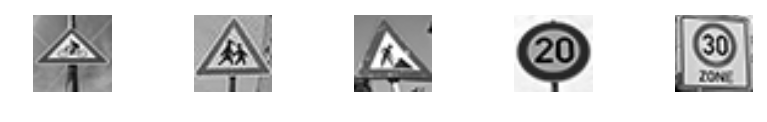

Model restored.
filename                      label   prediction          
bicycles-crossing.jpg         0       Speed limit (20km/h)
children-crossing.jpg         10      No passing for vechiles over 3.5 metric tons
road-work.jpg                 25      Road work           
speed-limit-20.jpg            3       Speed limit (60km/h)
speed-limit-30.jpg            13      Yield               


In [20]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

filenames = [
    'bicycles-crossing.jpg',
    'children-crossing.jpg',
    'road-work.jpg',
    'speed-limit-20.jpg',
    'speed-limit-30.jpg']

images = load_images(filenames)

saver = tf.train.Saver()

f = plt.figure(figsize=(n_images, 1))

for i, image in enumerate(images):
    image = image.reshape(32, 32)
    ax = f.add_subplot(1, 5, (i + 1))
    ax.axis('off')
    ax.imshow(image, cmap='gray')

plt.show()

with tf.Session() as session:
    saver.restore(session, "./model.ckpt")
    print("Model restored.")
    
    prediction_op = tf.argmax(logits, 1)
    predictions = session.run(prediction_op, feed_dict={features: images})
    
    print("{:30}{:8}{:20}".format("filename", "label", "prediction"))
    for idx, prediction in enumerate(predictions):
        print("{:30}{:<8}{:20}".format(filenames[idx], prediction, label_text(prediction)))

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

No, I don't get nearly as a good accuracy as I do from the test data. One one of the 5 images I found online was classified properly.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

Unfortunately, the correct labels don't appear to show up in the top 5 of the incorrectly labeled predictions.

Model restored.
Predicted (0) Speed limit (20km/h), Actual (29) bicycles-crossing.jpg


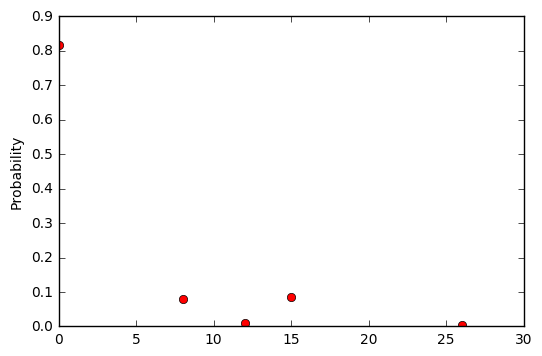

Predicted (10) No passing for vechiles over 3.5 metric tons, Actual (28) children-crossing.jpg


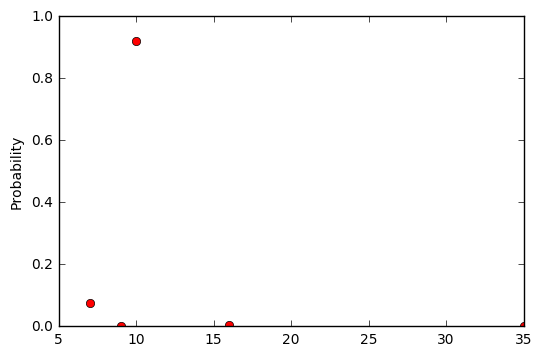

Predicted (25) Road work, Actual (25) road-work.jpg


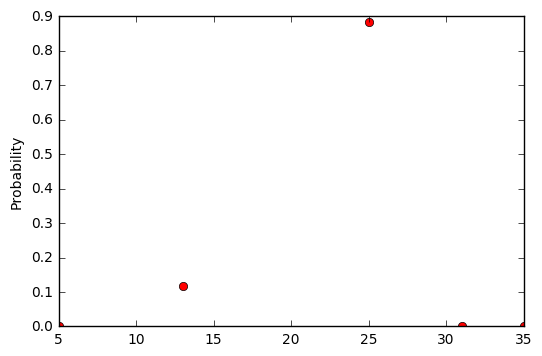

Predicted (3) Speed limit (60km/h), Actual (0) speed-limit-20.jpg


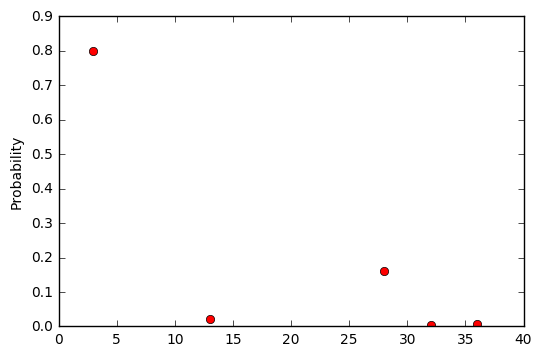

Predicted (13) Yield, Actual (1) speed-limit-30.jpg


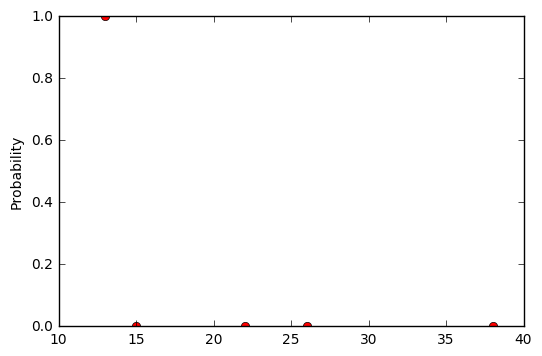

In [21]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import matplotlib.pyplot as plt

# Original version of this plotting function is from a response on the CarND forums.
def plot_top_k_probabilities(labels, probabilities, title):
    print(title)
    plt.plot(list(labels), list(probabilities), 'ro')
    plt.ylabel('Probability') 
    plt.show()

filenames = [
    'bicycles-crossing.jpg',
    'children-crossing.jpg',
    'road-work.jpg',
    'speed-limit-20.jpg',
    'speed-limit-30.jpg']

filename_labels = [
    29,
    28,
    25,
    0,
    1]

images = load_images(filenames)

saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, "./model.ckpt")
    print("Model restored.")
    
    prediction_op = tf.nn.softmax(logits)
    top_five = tf.nn.top_k(prediction_op, k=5, sorted=True, name=None)
    predictions = session.run(top_five, feed_dict={features: images})
    prediction_values, prediction_indices = predictions
    
    for idx, (probabilities, labels) in enumerate(zip(prediction_values, prediction_indices)):
        title = "Predicted ({}) {}, Actual ({}) {}".format(labels[0], label_text(labels[0]), filename_labels[idx], filenames[idx])
        plot_top_k_probabilities(labels, probabilities, title)
    
#     print("{:30}{:20}".format("filename", "prediction"))
#     for idx, prediction in enumerate(predictions):
#         print("{:30}{:20}".format(filenames[idx], label_text(prediction)))

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.